In [1]:
!pip install Music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 16.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.7 MB/s eta 0:00:00


In [11]:
import os
import json
import music21 as m21
import numpy as np
import tensorflow.keras as keras

KERN_DATASET_PATH = "/kaggle/input/dataset-folk/erk"
SAVE_DIR = "/kaggle/working/dataset"
SINGLE_FILE_DATASET = "/kaggle/working/file_dataset"
MAPPING_PATH = "/kaggle/working/mapping.json"
SEQUENCE_LENGTH = 64

ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]


def load_songs_in_kern(dataset_path):
    songs = []

    # go through all the files in dataset and load them with music21
    for path, subdirs, files in os.walk(dataset_path):
        for file in files:

            # consider only kern files
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs


def has_acceptable_durations(song, acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True


def transpose(song):
    # get key from the song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]

    # estimate key using music21
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition. E.g., Bmaj -> Cmaj
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    # transpose song by calculated interval
    tranposed_song = song.transpose(interval)
    return tranposed_song


def encode_song(song, time_step=0.25):
    encoded_song = []

    for event in song.flat.notesAndRests:

        # handle notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):

            # if it's the first time we see a note/rest, let's encode it. Otherwise, it means we're carrying the same
            # symbol in a new time step
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song


def preprocess(dataset_path):

    # load folk songs
    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)
    print(f"Loaded {len(songs)} songs.")

    for i, song in enumerate(songs):

        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue
        song = transpose(song)
        encoded_song = encode_song(song)
        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)

        if i % 10 == 0:
            print(f"Song {i} out of {len(songs)} processed")


def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song


def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    new_song_delimiter = "/ " * sequence_length
    songs = ""
    
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter

    songs = songs[:-1]

    with open(file_dataset_path, "w") as fp:
        fp.write(songs)

    return songs


def create_mapping(songs, mapping_path):
    mappings = {}

    songs = songs.split()
    vocabulary = list(set(songs))
    
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i

    with open(mapping_path, "w") as fp:
        json.dump(mappings, fp, indent=4)


def convert_songs_to_int(songs):
    int_songs = []

    # load mappings
    with open(MAPPING_PATH, "r") as fp:
        mappings = json.load(fp)

    songs = songs.split()

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs


def generate_training_sequences(sequence_length):
    # load songs and map them to int
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)

    inputs = []
    targets = []

    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    vocabulary_size = len(set(int_songs))
    # inputs size: (# of sequences, sequence length, vocabulary size)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    print(f"There are {len(inputs)} sequences.")

    return inputs, targets


def main():
    preprocess(KERN_DATASET_PATH)
    songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET, SEQUENCE_LENGTH)
    create_mapping(songs, MAPPING_PATH)

if __name__ == "__main__":
    main()

Loading songs...
Loaded 1700 songs.
Song 0 out of 1700 processed
Song 10 out of 1700 processed
Song 20 out of 1700 processed
Song 30 out of 1700 processed
Song 40 out of 1700 processed
Song 50 out of 1700 processed
Song 60 out of 1700 processed
Song 70 out of 1700 processed
Song 80 out of 1700 processed
Song 90 out of 1700 processed
Song 100 out of 1700 processed
Song 110 out of 1700 processed
Song 120 out of 1700 processed
Song 130 out of 1700 processed
Song 140 out of 1700 processed
Song 150 out of 1700 processed
Song 160 out of 1700 processed
Song 170 out of 1700 processed
Song 180 out of 1700 processed
Song 190 out of 1700 processed
Song 200 out of 1700 processed
Song 210 out of 1700 processed
Song 220 out of 1700 processed
Song 230 out of 1700 processed
Song 240 out of 1700 processed
Song 250 out of 1700 processed
Song 260 out of 1700 processed
Song 270 out of 1700 processed
Song 280 out of 1700 processed
Song 290 out of 1700 processed
Song 300 out of 1700 processed
Song 310 out o

# **Bi_LSTM**

There are 362178 sequences.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 512)              604160    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 38)                19494     
                                                                 
Total params: 623,654
Trainable params: 623,654
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5660/5660 [==============================] - 79s 12ms/step - loss: 0.6750 - accura

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5660/5660 [==============================] - 65s 12ms/step - loss: 0.1894 - accuracy: 0.9342


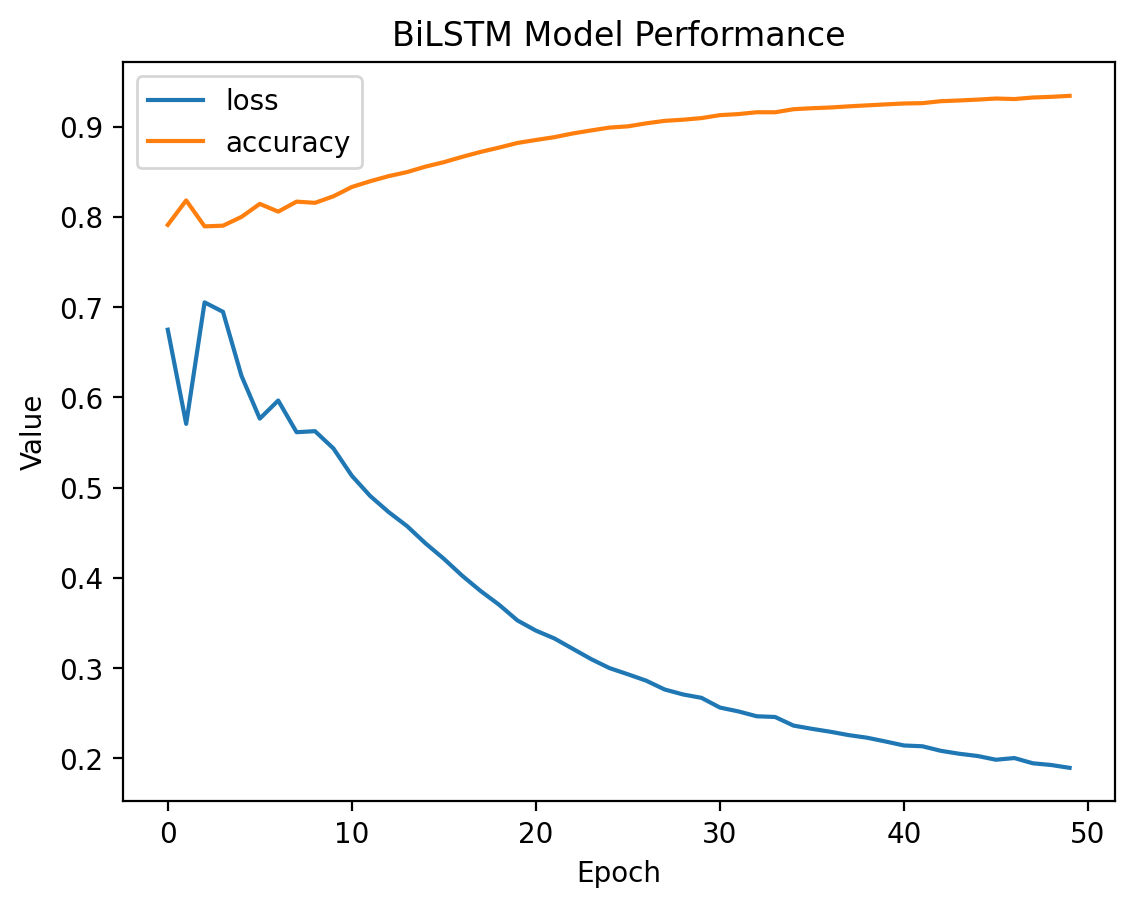

In [5]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = "/kaggle/working/model_BiLSTM.h5"

def build_model_BiLSTM(output_units, num_units, loss, learning_rate):
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.Bidirectional(keras.layers.LSTM(num_units[0]))(input)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(output_units, activation="softmax")(x)
    model_BiLSTM = keras.Model(input, output)

    model_BiLSTM.compile(loss=loss,
                         optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                         metrics=["accuracy"])
    model_BiLSTM.summary()
    return model_BiLSTM


def train_and_plot_model_BiLSTM(model_name, model_func):
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)

    model = build_model_BiLSTM(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)

    history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

    model.save(SAVE_MODEL_PATH)

    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title("BiLSTM Model Performance")
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()

if __name__ == "__main__":
    train_and_plot_model_BiLSTM("Bi_LSTM", build_model_BiLSTM)
    plt.show()

# **LSTM Model**

There are 362178 sequences.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               302080    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                                 
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5660/5660 [==============================] - 43s 7ms/step - loss: 0.6990 - accuracy: 0.7858
Epoch 2/50
5660/5660 [==============================] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5660/5660 [==============================] - 40s 7ms/step - loss: 0.4495 - accuracy: 0.8525
Epoch 9/50
5660/5660 [==============================] - 41s 7ms/step - loss: 0.4354 - accuracy: 0.8562
Epoch 10/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.4224 - accuracy: 0.8601
Epoch 11/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.4087 - accuracy: 0.8644
Epoch 12/50
3343/5660 [================>.............] - ETA: 16s - loss: 0.3978 - accuracy: 0.8679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5660/5660 [==============================] - 43s 8ms/step - loss: 0.3795 - accuracy: 0.8734
Epoch 15/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.3700 - accuracy: 0.8762
Epoch 16/50
5660/5660 [==============================] - 41s 7ms/step - loss: 0.3624 - accuracy: 0.8787
Epoch 17/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.3495 - accuracy: 0.8830
Epoch 18/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.3451 - accuracy: 0.8844
Epoch 19/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.3391 - accuracy: 0.8857
Epoch 20/50
5660/5660 [==============================] - 41s 7ms/step - loss: 0.3321 - accuracy: 0.8884
Epoch 21/50
5660/5660 [==============================] - 41s 7ms/step - loss: 0.3239 - accuracy: 0.8905
Epoch 22/50
5660/5660 [==============================] - 40s 7ms/step - loss: 0.3199 - accuracy: 0.8923
Epoch 23/50
5660/5660 [==============================] - 40s 7ms/step - loss

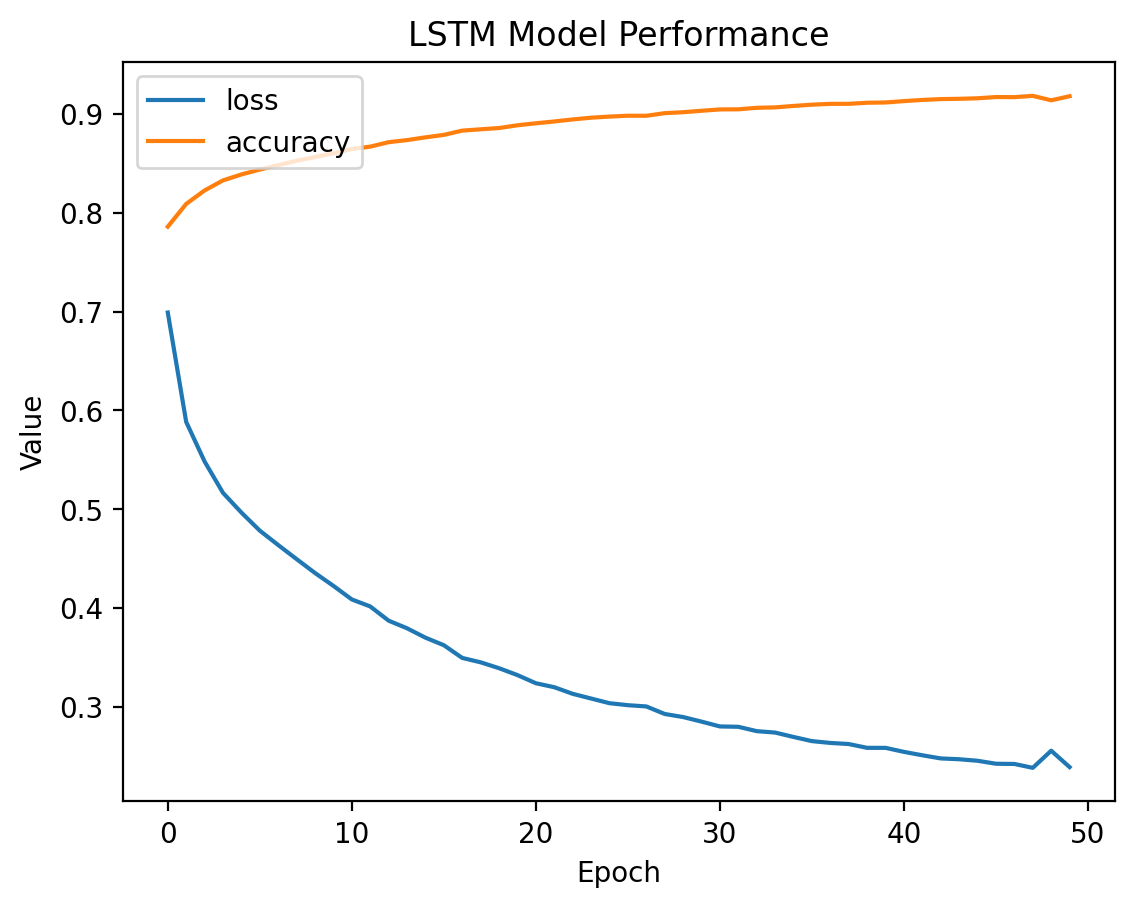

In [6]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = "/kaggle/working/model_LSTM.h5"


def build_model_LSTM(output_units, num_units, loss, learning_rate):
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(output_units, activation="softmax")(x)
    model_LSTM = keras.Model(input, output)

    model_LSTM.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                       metrics=["accuracy"])
    model_LSTM.summary()
    return model_LSTM


def train_and_plot_model(model_name, model_func):
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    model = model_func(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)
    history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)
    model.save(SAVE_MODEL_PATH)

    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title(f"{model_name} Model Performance")
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')


if __name__ == "__main__":
    train_and_plot_model("LSTM", build_model_LSTM)
    plt.show()

# **GRU**

There are 362178 sequences.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 gru (GRU)                   (None, 256)               227328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 38)                9766      
                                                                 
Total params: 237,094
Trainable params: 237,094
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5660/5660 [==============================] - 41s 7ms/step - loss: 0.6652 - accuracy: 0.7918
Epoch 2/50
5660/5660 [==============================] 

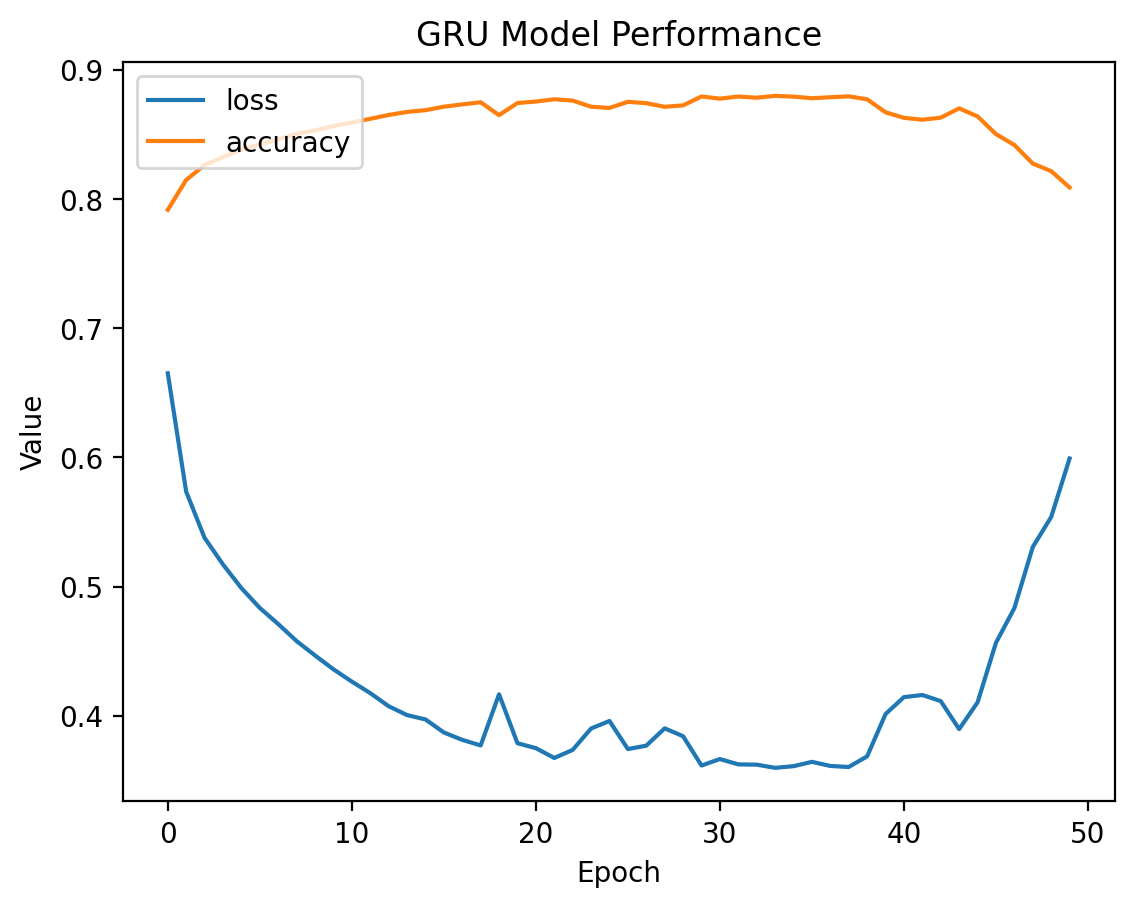

In [7]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = "/kaggle/working/model_GRU.h5"

def build_model_GRU(output_units, num_units, loss, learning_rate):
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.GRU(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(output_units, activation="softmax")(x)
    model_GRU = keras.Model(input, output)

    model_GRU.compile(loss=loss,
                      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      metrics=["accuracy"])
    model_GRU.summary()
    return model_GRU


def train_and_plot_model_GRU(model_name, model_func):

    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    model = build_model_GRU(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)
    history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)
    model.save(SAVE_MODEL_PATH)
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title("GRU Model Performance")
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()
if __name__ == "__main__":
    train_and_plot_model_GRU("GRU", build_model_GRU)
    plt.show()

# **SIMPLE_RNN**

There are 362178 sequences.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               75520     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 85,286
Trainable params: 85,286
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5660/5660 [==============================] - 355s 62ms/step - loss: 0.7426 - accuracy: 0.7817
Epoch 2/50
5660/5660 [==============================] - 

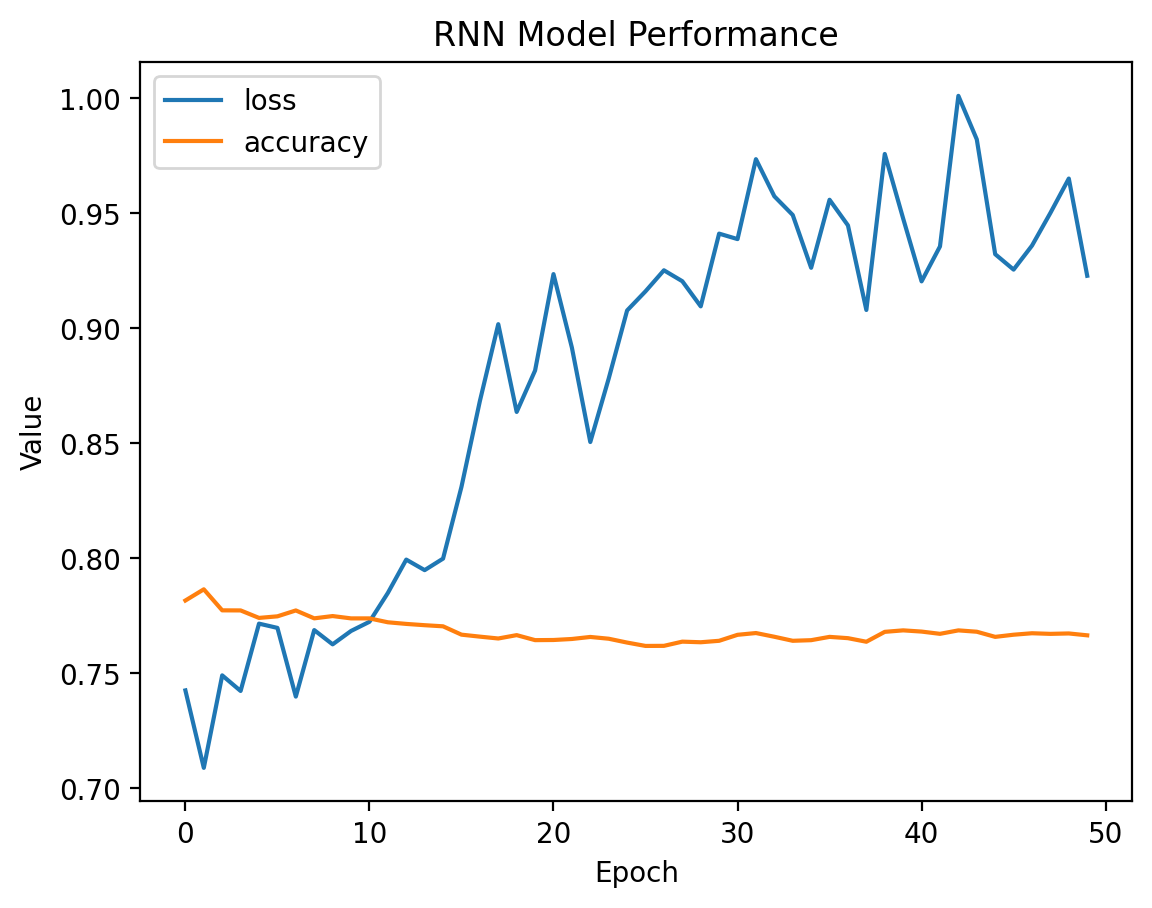

In [6]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = "/kaggle/working/model_RNN.h5"

def build_model_RNN(output_units, num_units, loss, learning_rate):
    # Create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.SimpleRNN(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(output_units, activation="softmax")(x)
    model_RNN = keras.Model(input, output)
    model_RNN.compile(loss=loss,
                      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      metrics=["accuracy"])
    model_RNN.summary()
    return model_RNN


def train_and_plot_model_RNN(model_name, model_func):
    inputs, targets = generate_training_sequences(SEQUENCE_LENGTH)
    model = build_model_RNN(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)
    history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)
    model.save(SAVE_MODEL_PATH)
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title("RNN Model Performance")
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()
if __name__ == "__main__":
    train_and_plot_model_RNN("RNN", build_model_RNN)

In [15]:
import json
import numpy as np
import tensorflow.keras as keras
import music21 as m21
SEQUENCE_LENGTH = 64
MAPPING_PATH = "/kaggle/working/mapping.json"


class MelodyGenerator:

    def __init__(self, model_path="model.h5"):
        self.model_path = model_path
        self.model = keras.models.load_model(model_path)

        with open(MAPPING_PATH, "r") as fp:
            self._mappings = json.load(fp)

        self._start_symbols = ["/"] * SEQUENCE_LENGTH


    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):
        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed
        seed = [self._mappings[symbol] for symbol in seed]

        for _ in range(num_steps):
            seed = seed[-max_sequence_length:]
            onehot_seed = keras.utils.to_categorical(seed, num_classes=len(self._mappings))
            # (1, max_sequence_length, num of symbols in the vocabulary)
            onehot_seed = onehot_seed[np.newaxis, ...]
            probabilities = self.model.predict(onehot_seed)[0]
            # [0.1, 0.2, 0.1, 0.6] -> 1
            output_int = self._sample_with_temperature(probabilities, temperature)
            seed.append(output_int)
            output_symbol = [k for k, v in self._mappings.items() if v == output_int][0]
            
            if output_symbol == "/":
                break
            melody.append(output_symbol)

        return melody


    def _sample_with_temperature(self, probabilities, temperature):
        predictions = np.log(probabilities) / temperature
        probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(probabilities))  # [0, 1, 2, 3]
        index = np.random.choice(choices, p=probabilities)

        return index


    def save_melody(self, melody, step_duration=0.25, file_format="midi", file_name="melody.mid"):
        stream = m21.stream.Stream()
        start_symbol = None
        step_counter = 1

        # parse all the symbols in the melody and create note/rest objects
        for i, symbol in enumerate(melody):

            # handle case in which we have a note/rest
            if symbol != "_" or i + 1 == len(melody):
                
                if start_symbol is not None:
                    quarter_length_duration = step_duration * step_counter  # 0.25 * 4 = 1

                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                    else:
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                    stream.append(m21_event)
                    step_counter = 1
                start_symbol = symbol

            else:
                step_counter += 1

        # write the m21 stream to a file
        stream.write(file_format, file_name)
        
if __name__ == "__main__":
    # LSTM model
    mg_lstm = MelodyGenerator(model_path="/kaggle/input/models/Models/model_LSTM.h5")
    seed = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"
    melody_lstm = mg_lstm.generate_melody(seed, 500, SEQUENCE_LENGTH, 0.3)
    mg_lstm.save_melody(melody_lstm, file_name="/kaggle/working/melody_lstm.mid")

    # BiLSTM model
    mg_bilstm = MelodyGenerator(model_path="/kaggle/input/models/Models/model_BiLSTM.h5")
    seed_bilstm = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"
    melody_bilstm = mg_bilstm.generate_melody(seed, 500, SEQUENCE_LENGTH, 0.3)
    mg_bilstm.save_melody(melody_bilstm, file_name="/kaggle/working/melody_bilstm.mid")

    # GRU model
    mg_gru = MelodyGenerator(model_path="/kaggle/input/models/Models/model_GRU.h5")
    seed_gru = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"
    melody_gru = mg_gru.generate_melody(seed, 500, SEQUENCE_LENGTH, 0.3)
    mg_gru.save_melody(melody_gru, file_name="/kaggle/working/melody_gru.mid")

    # RNN model
    mg_rnn = MelodyGenerator(model_path="/kaggle/input/models/Models/model_RNN.h5")
    seed_rnn = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"
    melody_rnn = mg_rnn.generate_melody(seed, 500, SEQUENCE_LENGTH, 0.3)
    mg_rnn.save_melody(melody_rnn, file_name="/kaggle/working/melody_rnn.mid")


1/1 [==============================] - 0s 26ms/step
